# Plans for Exploratory Data Analysis

- [x] Check sales for different months

- [x] Check sales for different days of the week

- [x] Check sales between weekdays and weekends

- [x] Check sales between regular days and holidays

- [x] Check the effect of promotion on sales

- [x] Check the effect of promotion on different product families

- [x] Check how the frequency of promotions on different product families affect the sales number on them (More observations needed if really needed for use to see if the connection between the frequency and how they increase sales)

- [ ] <span style="color:red">*Are there any product families which are frequently bought together?*</span>

- [x] Is there a difference in the volume of sales based on if the holiday is regional, national, or local?

- [x] Do holidays boost the sales of any product family?

- [x] How does the type of the store affects sales?

- [x] How does the cluster of the store affects sales?

- [x] Does oil price have any effect on the volume of sales?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import AgglomerativeClustering
import scipy

In [2]:
train_df = pd.read_csv("data/train.csv")
oil_df = pd.read_csv("data/oil.csv")
holidays_df = pd.read_csv("data/holidays_events.csv")
stores_df = pd.read_csv("data/stores.csv")
transactions = pd.read_csv("data/transactions.csv")

In [3]:
train_df["id"] = train_df["id"].astype("int32")
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["sales"] = train_df["sales"].astype("float32")
train_df["onpromotion"] = train_df["onpromotion"].astype("float16")
train_df["family"] = train_df["family"].astype("category")
train_df["store_nbr"] = train_df["store_nbr"].astype("int32")

In [4]:
train_df = train_df.loc[train_df["date"] < "2017-04-16"]

In [5]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


### Sales during different months

In [5]:
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["month"] = train_df["month"].astype("category")

<AxesSubplot: xlabel='month', ylabel='sales'>

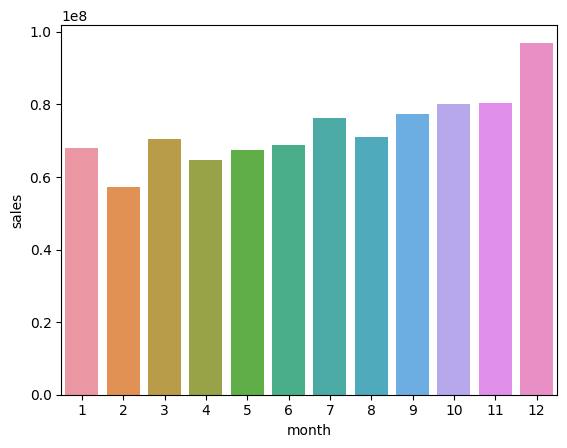

In [6]:
sales_months = train_df.loc[train_df["year"] < 2017]
sales_months = sales_months.groupby("month")["sales"].sum().reset_index()
sns.barplot(sales_months, x="month", y="sales")

### Sales on different days of the week

In [7]:
def get_day(date):
    return date.strftime('%A')

In [8]:
train_df["day"] = train_df["date"].apply(get_day)
train_df["day"] = train_df["day"].astype("category")

<AxesSubplot: xlabel='day'>

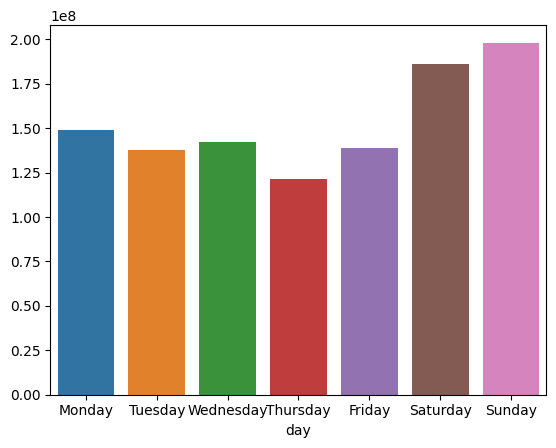

In [9]:
day_cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_on_days = train_df.groupby(by="day")["sales"].sum().reindex(day_cats)
sns.barplot(x=sales_on_days.index, y=sales_on_days.values)

In [10]:
1 - (sales_on_days.values.mean() / sales_on_days['Sunday'])

0.22556912899017334

In [11]:
1 - (sales_on_days['Thursday'] / sales_on_days.values.mean())

0.20937341451644897

The highest grossing day is Sunday, the sales are 23 % bigger than average.

The lowest grossing day is Thursday, the sales are 20 % smaller than average. Possibly because weekend is coming soon and people plan to go at that time.

### Sales on weekdays and weekends

In [12]:
def which_week_part(day):
    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    
    if day in weekdays:
        return "Weekday"
    else:
        return "Weekend"

In [13]:
train_df["week_part"] = train_df["day"].apply(which_week_part)
train_df["week_part"] = train_df["week_part"].astype("category")

<AxesSubplot: xlabel='week_part'>

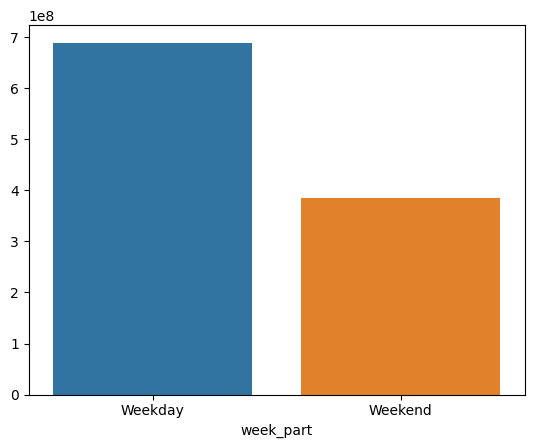

In [14]:
sales_comparison_weekparts = train_df.groupby(by="week_part")["sales"].sum()
sns.barplot(x=sales_comparison_weekparts.index, y=sales_comparison_weekparts.values)

First it seems that during the weekdays the sales are much higher but so far the fact that weekdays consist of 5 days and weekends only from 2 days were ignored so let's adjust the values in the next step.

<AxesSubplot: xlabel='week_part'>

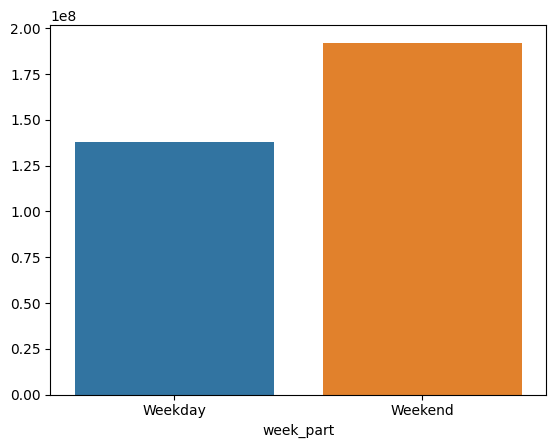

In [15]:
sales_comparison_weekparts["Weekday"] = sales_comparison_weekparts["Weekday"] / 5
sales_comparison_weekparts["Weekend"] = sales_comparison_weekparts["Weekend"] / 2
sns.barplot(x=sales_comparison_weekparts.index, y=sales_comparison_weekparts.values)

In [16]:
sales_comparison_weekparts["Weekday"] / sales_comparison_weekparts["Weekend"]

0.717932155355408

The adjusted values show the average sale on a weekday or on a weekend and as we can see this way the sales on a weekend are higher. Average weekday sales are only 72% of the average weekend sales.

### Sales between regular days and holidays

In [17]:
holidays_df = holidays_df[holidays_df["transferred"] == False]
holidays_df["date"] = pd.to_datetime(holidays_df["date"])
holiday_dates = holidays_df["date"].tolist()

def is_holiday(date):
    if date in holiday_dates:
        return True
    else:
        return False

In [18]:
train_df["is_holiday"] = train_df["date"].apply(is_holiday)

In [19]:
sales_comparison_holiday = train_df.groupby("is_holiday")["sales"].sum()

In [20]:
number_of_all_days = train_df.iloc[-1]["date"] - train_df.iloc[0]["date"]
all_days_count = number_of_all_days.days
holiday_days = train_df[train_df["is_holiday"] == True]
holidays_count = len(holiday_days.groupby("date"))
regular_days_count = all_days_count - holidays_count

In [21]:
sales_comparison_holiday

is_holiday
False    903645056.0
True     169999904.0
Name: sales, dtype: float32

<AxesSubplot: xlabel='is_holiday'>

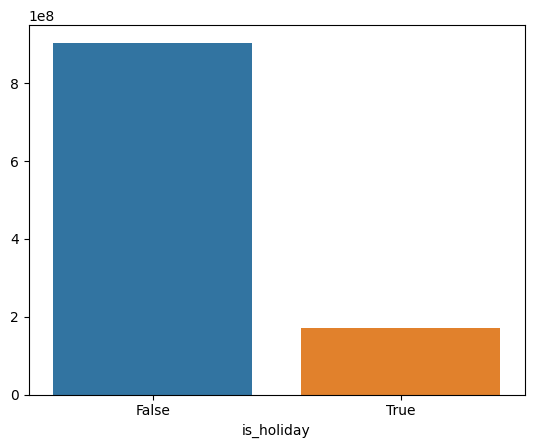

In [22]:
sns.barplot(x=sales_comparison_holiday.index, y=sales_comparison_holiday.values)

In [23]:
sales_comparison_holiday[False] = sales_comparison_holiday[False] / regular_days_count
sales_comparison_holiday[True] = sales_comparison_holiday[True] / holidays_count

In [24]:
sales_comparison_holiday

is_holiday
False    625792.975069
True     699588.082305
Name: sales, dtype: float64

<AxesSubplot: xlabel='is_holiday'>

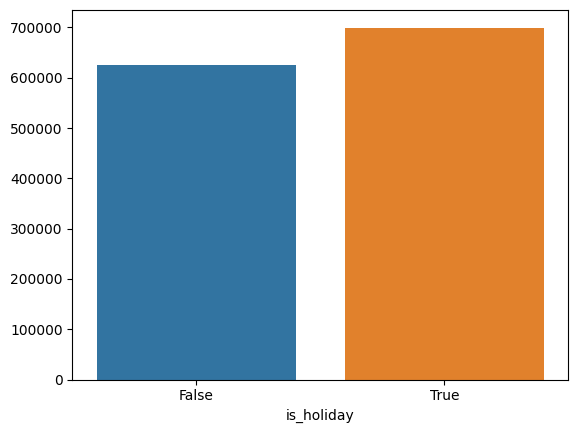

In [25]:
sns.barplot(x=sales_comparison_holiday.index, y=sales_comparison_holiday.values)

In [26]:
1 - sales_comparison_holiday[False] / sales_comparison_holiday[True]

0.10548365402707371

On average the sales on holidays increase by around 10.5%.

### Effect of promotion on sales

In [27]:
bin_promotion = train_df[train_df["onpromotion"] >0]
product_families = list(set(bin_promotion["family"].tolist()))
for product_family in product_families:
    temp_df = bin_promotion[bin_promotion["family"] == product_family]
    cut_bin = pd.qcut(temp_df["onpromotion"], q=3, duplicates="drop")

In [28]:
train_df["is_promoted"] = train_df["onpromotion"] > 0

In [29]:
train_df.groupby("is_promoted").count()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,week_part,is_holiday
is_promoted,,,,,,,,,,,
False,2389559,2389559,2389559,2389559,2389559,2389559,2389559,2389559,2389559,2389559,2389559
True,611329,611329,611329,611329,611329,611329,611329,611329,611329,611329,611329


<AxesSubplot: xlabel='is_promoted'>

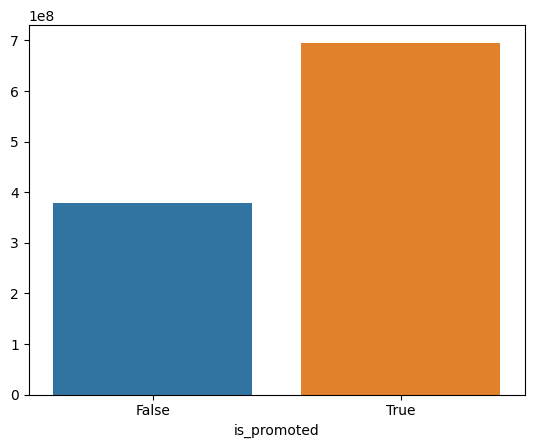

In [30]:
is_promoted_sales = train_df.groupby("is_promoted")["sales"].sum()
sns.barplot(x=is_promoted_sales.index, y=is_promoted_sales.values)

In [31]:
is_promoted_sales.values[1] / is_promoted_sales.values[0]

1.8392806

In [32]:
is_promoted_mean = train_df.groupby("is_promoted")["sales"].mean()

<AxesSubplot: xlabel='is_promoted'>

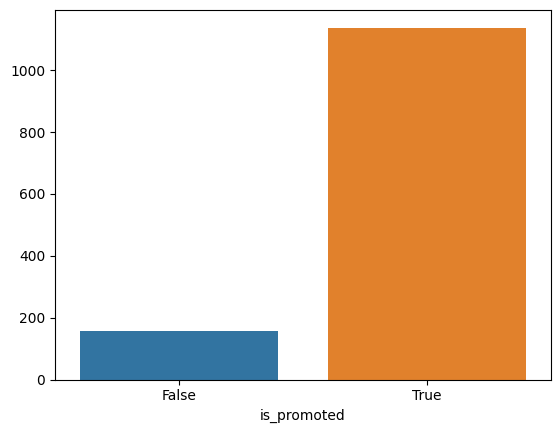

In [33]:
sns.barplot(x=is_promoted_mean.index, y=is_promoted_mean.values)

<AxesSubplot: xlabel='onpromotion', ylabel='sales'>

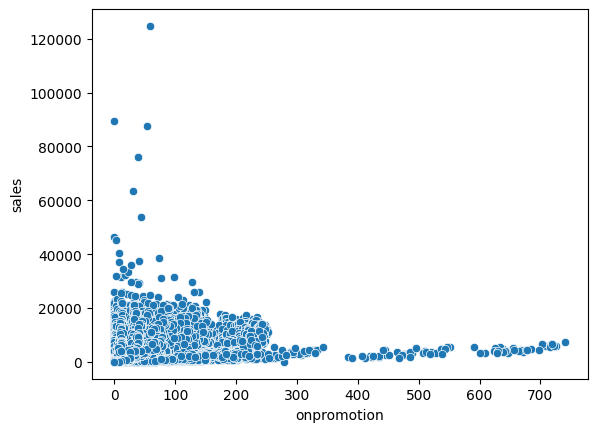

In [34]:
sns.scatterplot(train_df, x="onpromotion", y="sales")

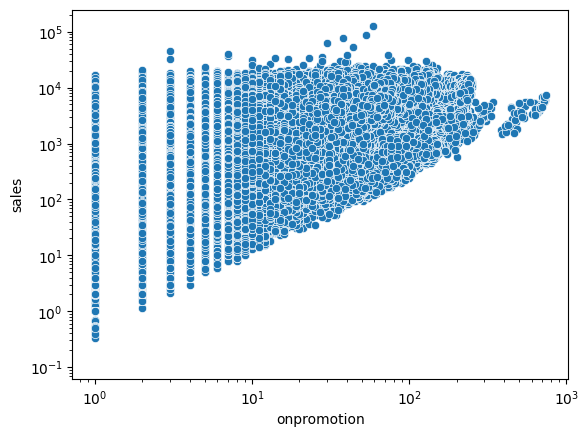

In [35]:
sns.scatterplot(train_df, x="onpromotion", y="sales")
plt.xscale("log")
plt.yscale("log")

### Effect of promotion on different product families

In [36]:
promotion_families = train_df.groupby(["family", "is_promoted"])["sales"].sum()
promotion_families_count = train_df.groupby(["family", "is_promoted"])["sales"].count()

promotion_families = promotion_families / promotion_families_count

In [37]:
ratio_family_promotion = pd.Series(dtype=str)
for family in product_families:
    ratio = {family : promotion_families[family][True] / promotion_families[family][False]}
    ratio_family_promotion = pd.concat([ratio_family_promotion, pd.Series(ratio)])

In [38]:
ratio_family_promotion = ratio_family_promotion.reset_index()
ratio_family_promotion = ratio_family_promotion.rename(columns={"index":"family", 0:"promo_elasticity"})

In [39]:
ratio_family_promotion_mean = ratio_family_promotion["promo_elasticity"].mean()
ratio_family_promotion_median = ratio_family_promotion["promo_elasticity"].median()
ratio_family_promotion_quantiles = ratio_family_promotion["promo_elasticity"].quantile([0.25, 0.75])

In [40]:
ratio_family_promotion["bigger_mean_promo_elasticity"] = ratio_family_promotion["promo_elasticity"] > ratio_family_promotion_mean
ratio_family_promotion["bigger_median_promo_elasticity"] = ratio_family_promotion["promo_elasticity"] > ratio_family_promotion_median

In [41]:
def family_quantile(number):
    if number < ratio_family_promotion_quantiles[0.25]:
        return "Low"
    elif number < ratio_family_promotion_quantiles[0.75]:
        return "Average"
    else:
        return "High"

In [42]:
ratio_family_promotion["quantiles_promo_elasticity"] = ratio_family_promotion["promo_elasticity"].apply(family_quantile)

In [43]:
ratio_family_promotion.sort_values(by="promo_elasticity")

,family,promo_elasticity,bigger_mean_promo_elasticity,bigger_median_promo_elasticity,quantiles_promo_elasticity
11,PREPARED FOODS,1.238524,False,False,Low
5,GROCERY II,1.289696,False,False,Low
13,EGGS,1.357560,False,False,Low
6,MAGAZINES,1.366491,False,False,Low
17,CLEANING,1.428192,False,False,Low
9,DELI,1.450491,False,False,Low
19,BREAD/BAKERY,1.516377,False,False,Low
14,PERSONAL CARE,1.533630,False,False,Low
1,MEATS,1.541837,False,False,Average
8,POULTRY,1.547886,False,False,Average


### Effect of frequency of promotions on different product families

In [44]:
f_df = train_df[train_df["onpromotion"] > 0]
f_df = f_df.sort_values(by=["date", "store_nbr"])

# create a new column to keep track of the last promotion date for each product family in each store
f_df["last_promo_date"] = f_df.groupby(["store_nbr", "family"])["date"].transform(lambda x: x.shift().where(x.shift() != 0, "First"))
f_df = f_df.dropna()
# convert the date column to datetime
f_df["date"] = pd.to_datetime(f_df["date"])
f_df["last_promo_date"] = pd.to_datetime(f_df["last_promo_date"])
# calculate the number of days between the last promotion and the current date
f_df["days_since_last_promo"] = (f_df["date"] - f_df["last_promo_date"]).dt.days - 1
f_df = f_df[["id", "days_since_last_promo"]]
train_df = train_df.merge(f_df, on="id", how="left").fillna(-1)
train_df["days_since_last_promo"] = train_df["days_since_last_promo"].astype("int32")

In [45]:
bins = [-np.inf, 0, 7, 14, 28, np.inf]
labels = ["Never", "Less than a week", "Between 1-2 weeks", "Between 2-4 weeks", "More than 4 weeks"]
train_df["bin_last_promo"] = pd.cut(train_df["days_since_last_promo"], bins=bins, labels=labels) 

bin_last_promo
Never                351.673096
Less than a week     524.120300
Between 1-2 weeks    216.519165
Between 2-4 weeks    127.810127
More than 4 weeks     81.777107
Name: sales, dtype: float32


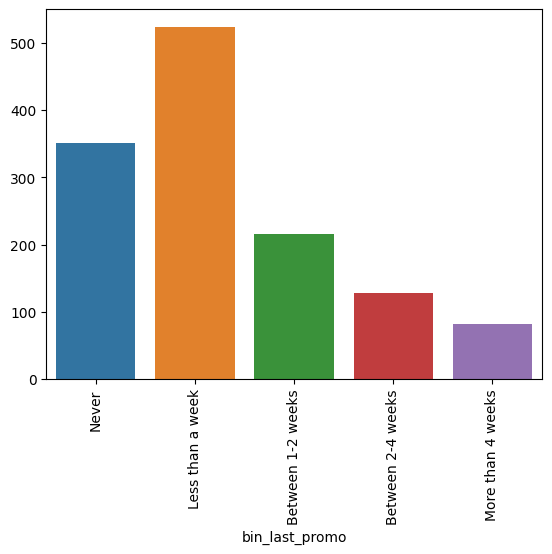

In [46]:
frequency_effect_promo = train_df.groupby("bin_last_promo")["sales"].mean()
sns.barplot(x=frequency_effect_promo.index, y=frequency_effect_promo.values)
plt.xticks(rotation=90)
print(frequency_effect_promo)

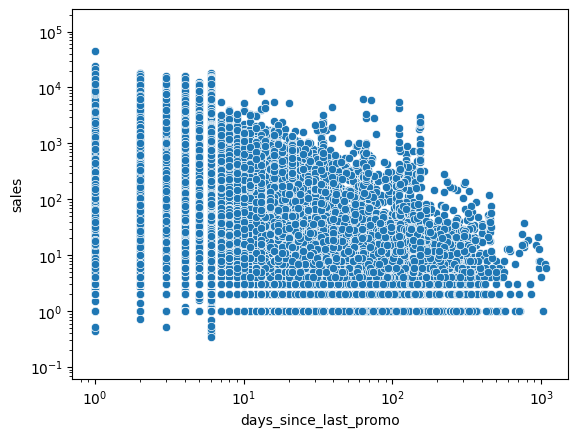

In [47]:
sns.scatterplot(data=train_df, x="days_since_last_promo", y="sales")
plt.xscale("log")
plt.yscale("log")

### Frequently bought together product families

In [48]:
together_df = train_df.groupby(["store_nbr", "family"], group_keys=False)
together_df = together_df.apply(lambda x: x.sort_values(["date"]))
together_df["sales_pct_change"] = together_df["sales"].pct_change()
together_df = together_df.dropna()
together_df = together_df[together_df["sales_pct_change"] != np.inf]

In [49]:
def find_similar_families(df):
    # Pivot the data to get one row per store, day, and family
    df_pivot = pd.pivot_table(df, values='sales_pct_change', index=['store_nbr', 'date'], columns='family', fill_value=0)
    
    # Normalize the sales_pct_change values to have mean 0 and standard deviation 1
    df_pivot_norm = (df_pivot - df_pivot.mean()) / df_pivot.std()
    
    # Perform hierarchical clustering on the normalized sales_pct_change values
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.0)
    clusters = model.fit_predict(df_pivot_norm.values)
    
    # Assign each family to a cluster
    cluster_assignments = pd.Series(clusters, index=df_pivot.columns)
    
    # Return a DataFrame with the cluster assignments for each family
    return cluster_assignments.to_frame('cluster')

### Effect of holiday type

In [50]:
train_df = pd.merge(train_df, holidays_df[["date", "locale"]], on="date", how="left")
train_df = train_df.fillna("Not holiday")
train_df["locale"] = train_df["locale"].astype("category")

locale
Local          365.266891
National       423.528748
Not holiday    351.905615
Regional       387.005799
Name: sales, dtype: float64

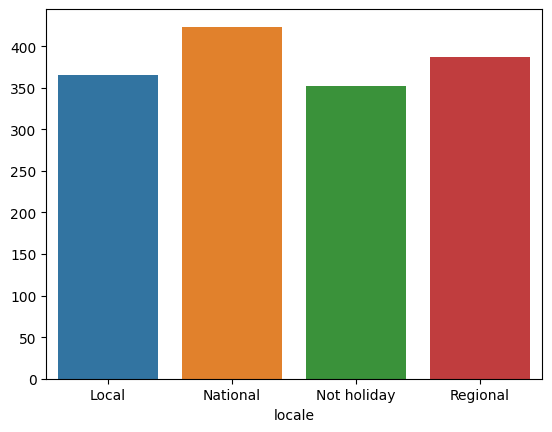

In [51]:
effect_holiday_type = train_df.groupby("locale")["sales"].sum() / train_df.groupby("locale")["sales"].count()
sns.barplot(x=effect_holiday_type.index, y=effect_holiday_type.values)
effect_holiday_type

### Holidays effect on product families

In [52]:
holiday_effect_family = train_df.groupby(["is_holiday", "family"])["sales"].sum() / train_df.groupby(["is_holiday", "family"])["sales"].count()
holiday_effect_pct = holiday_effect_family[True] / holiday_effect_family[False]
holiday_effect_pct.sort_values(ascending=False)

family
FROZEN FOODS                  1.808132
LIQUOR,WINE,BEER              1.461421
MAGAZINES                     1.343795
PLAYERS AND ELECTRONICS       1.310027
HOME AND KITCHEN I            1.219976
GROCERY II                    1.206425
HOME CARE                     1.204795
PET SUPPLIES                  1.200547
LADIESWEAR                    1.191936
CELEBRATION                   1.190363
BEAUTY                        1.163734
LAWN AND GARDEN               1.158011
BABY CARE                     1.148504
SCHOOL AND OFFICE SUPPLIES    1.143909
GROCERY I                     1.139558
PRODUCE                       1.138061
BEVERAGES                     1.126571
PERSONAL CARE                 1.120838
HOME AND KITCHEN II           1.119218
POULTRY                       1.106663
DAIRY                         1.097260
AUTOMOTIVE                    1.095995
HARDWARE                      1.088394
DELI                          1.079690
BOOKS                         1.079008
CLEANING          

### Store type effect

In [53]:
train_df = pd.merge(train_df, stores_df[["store_nbr", "type", "cluster"]], on="store_nbr")
train_df["type"] = train_df["type"].astype("category")
train_df["cluster"] = train_df["cluster"].astype("category")

type
A    708.378157
B    328.275238
C    197.790649
D    352.084517
E    270.285492
Name: sales, dtype: float64

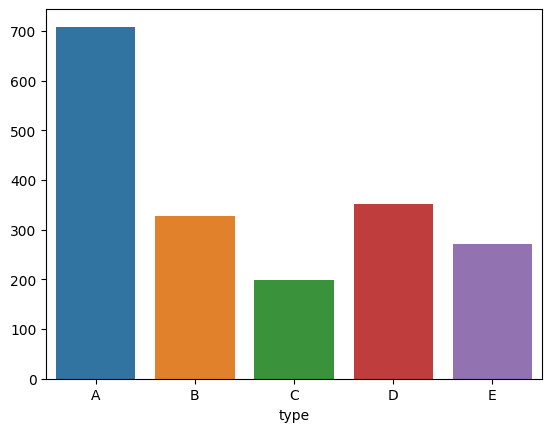

In [54]:
store_type_effect = train_df.groupby("type")["sales"].sum() / train_df.groupby("type")["sales"].count()
sns.barplot(x = store_type_effect.index, y = store_type_effect.values)
store_type_effect

### Store cluster effect

cluster
1      327.022807
2      261.025724
3      194.926528
4      297.537876
5     1120.118383
6      344.315430
7      139.772223
8      648.976062
9      275.725876
10     257.006589
11     605.829685
12     325.591952
13     325.806160
14     710.922315
15     199.447516
16     239.594710
17     594.106644
Name: sales, dtype: float64

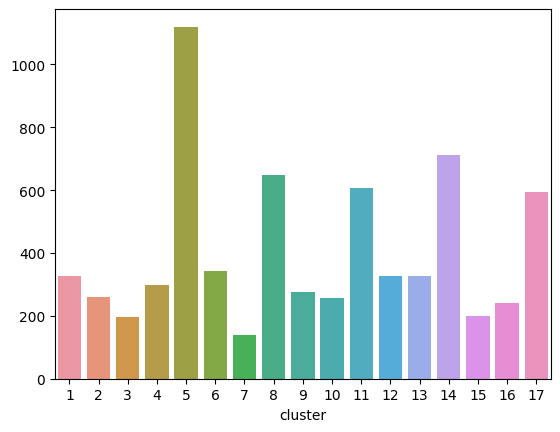

In [55]:
store_cluster_effect = train_df.groupby("cluster")["sales"].sum() / train_df.groupby("cluster")["sales"].count()
sns.barplot(x = store_cluster_effect.index, y = store_cluster_effect.values)
store_cluster_effect

### Effect of oil price on sales

Pearson correlation: -0.6073232445871358
Spearman correlation: -0.6377903384508934


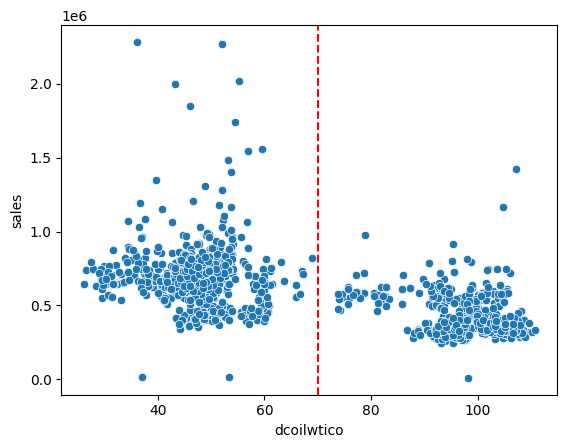

In [56]:
agg_sales = train_df.groupby("date")["sales"].sum().to_frame()
oil_df = oil_df.fillna(method="ffill")
oil_df = oil_df.dropna()
oil_df["date"] = pd.to_datetime(oil_df["date"])
agg_sales = pd.merge(agg_sales, oil_df, on="date", how="right")
agg_sales = agg_sales.dropna()
sns.scatterplot(agg_sales, x="dcoilwtico", y="sales").axvline(x=70, color='r', linestyle='--')
print(f"Pearson correlation: {agg_sales['sales'].corr(agg_sales['dcoilwtico'], method='pearson')}")
print(f"Spearman correlation: {agg_sales['sales'].corr(agg_sales['dcoilwtico'], method='spearman')}") 

### Effect of oil price on different product families

In [57]:
oil_family_sales = pd.merge(train_df[["date", "sales", "family"]], oil_df, on="date", how="left")
oil_family_sales.dropna(inplace=True)

In [58]:
oil_family_sales["bigger_70"] = oil_family_sales["dcoilwtico"] > 70
oil_family_effect = oil_family_sales.groupby(["family", "bigger_70"])["sales"].mean().reset_index()

In [59]:
oil_bigger_true = oil_family_effect.loc[oil_family_effect["bigger_70"], 'sales'].reset_index()
oil_bigger_false = oil_family_effect.loc[~oil_family_effect["bigger_70"], 'sales'].reset_index()

In [60]:
oil_bigger_true = pd.merge(oil_bigger_true, oil_family_effect[["family"]], left_on="index", right_on=oil_family_effect.index)
oil_bigger_false = pd.merge(oil_bigger_false, oil_family_effect[["family"]], left_on="index", right_on=oil_family_effect.index)

In [61]:
oil_bigger_true = oil_bigger_true.drop("index", axis=1)
oil_bigger_false = oil_bigger_false.drop("index", axis=1)

In [62]:
oil_elasticity = oil_bigger_true.sales / oil_bigger_false.sales
oil_elasticity = pd.merge(oil_bigger_true[["family"]], oil_elasticity, left_on=oil_bigger_true.index, right_on=oil_elasticity.index)

In [63]:
oil_elasticity = oil_elasticity.drop('key_0', axis=1)
oil_elasticity = oil_elasticity.rename(columns={"sales": "oil_elasticity"})

In [64]:
oil_elasticity_mean = oil_elasticity["oil_elasticity"].mean()
oil_elasticity_median = oil_elasticity["oil_elasticity"].median()
oil_elasticity_quantiles = oil_elasticity["oil_elasticity"].quantile([0.25, 0.75])

In [65]:
oil_elasticity["smaller_mean_oil_elasticity"] = oil_elasticity["oil_elasticity"] < oil_elasticity_mean
oil_elasticity["smaller_median_oil_elasticity"] = oil_elasticity["oil_elasticity"] < oil_elasticity_median

In [66]:
def family_oil_quantile(number):
    if number < oil_elasticity_quantiles[0.25]:
        return "High"
    elif number < oil_elasticity_quantiles[0.75]:
        return "Average"
    else:
        return "Low"

In [67]:
oil_elasticity["quantiles_oil_elasticity"] = oil_elasticity["oil_elasticity"].apply(family_oil_quantile)

In [68]:
oil_elasticity.sort_values(by="oil_elasticity")

,family,oil_elasticity,smaller_mean_oil_elasticity,smaller_median_oil_elasticity,quantiles_oil_elasticity
4,BOOKS,0.000000,True,True,High
1,BABY CARE,0.069063,True,True,High
23,MAGAZINES,0.072744,True,True,High
16,HOME AND KITCHEN II,0.106462,True,True,High
31,SCHOOL AND OFFICE SUPPLIES,0.171442,True,True,High
26,PET SUPPLIES,0.209777,True,True,High
15,HOME AND KITCHEN I,0.210429,True,True,High
27,PLAYERS AND ELECTRONICS,0.243104,True,True,High
6,CELEBRATION,0.256588,True,True,Average
18,HOME CARE,0.261844,True,True,Average


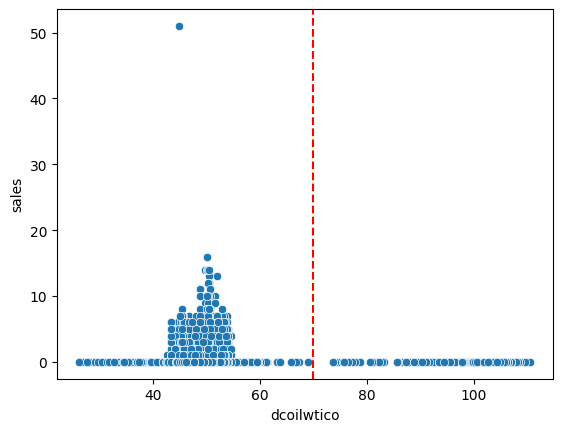

In [69]:
sns.scatterplot(oil_family_sales[oil_family_sales["family"] == "BOOKS"], x="dcoilwtico", y="sales").axvline(x=70, color='r', linestyle='--')

### Exporting the data to CSV